# Packages Used

In [ ]:
!pip uninstall umap
!pip install umap-learn
!pip install umap-learn[plot]

In [ ]:
!pip install hdbscan

In [ ]:
#@title Setup
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import itertools
import random
np.random.seed(42)
random.seed(42)

import hdbscan
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from scipy.optimize import linear_sum_assignment
import umap.umap_ as umap
import umap.plot

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

### Given plotmat.py

In [ ]:
def plot_mat(mat, xticklabels = None, yticklabels = None, pic_fname = None, size=(-1,-1), if_show_values = True,
             colorbar = True, grid = 'k', xlabel = None, ylabel = None, title = None, vmin=None, vmax=None):
    if size == (-1, -1):
        size = (mat.shape[1] / 3, mat.shape[0] / 3)

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1,1,1)

    # im = ax.imshow(mat, cmap=plt.cm.Blues)
    im = ax.pcolor(mat, cmap=plt.cm.Blues, linestyle='-', linewidth=0.5, edgecolor=grid, vmin=vmin, vmax=vmax)
    
    if colorbar:
        plt.colorbar(im,fraction=0.046, pad=0.06)
    # tick_marks = np.arange(len(classes))
    # Ticks
    lda_num_topics = mat.shape[0]
    nmf_num_topics = mat.shape[1]
    yticks = np.arange(lda_num_topics)
    xticks = np.arange(nmf_num_topics)
    ax.set_xticks(xticks + 0.5)
    ax.set_yticks(yticks + 0.5)
    if xticklabels is None:
        xticklabels = [str(i) for i in xticks]
    if yticklabels is None:
        yticklabels = [str(i) for i in yticks]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    # Minor ticks
    # ax.set_xticks(xticks, minor=True);
    # ax.set_yticks(yticks, minor=True);
    # ax.set_xticklabels([], minor=True)
    # ax.set_yticklabels([], minor=True)

    # ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)

    # tick labels on all four sides
    ax.tick_params(labelright = True, labeltop = False)

    if ylabel:
        plt.ylabel(ylabel, fontsize=15)
    if xlabel:
        plt.xlabel(xlabel, fontsize=15)
    if title:
        plt.title(title, fontsize=15)

    # im = ax.imshow(mat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.invert_yaxis()

    # thresh = mat.max() / 2

    def show_values(pc, fmt="%.0f", **kw):
        pc.update_scalarmappable()
        ax = pc.axes
        for p, color, value in itertools.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw, fontsize=10)

    if if_show_values:
        show_values(im)
    # for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    #     ax.text(j, i, "{:.2f}".format(mat[i, j]), fontsize = 4,
    #              horizontalalignment="center",
    #              color="white" if mat[i, j] > thresh else "black")

    plt.tight_layout()
    if pic_fname:
        plt.savefig(pic_fname, dpi=300, transparent=True)
    plt.show()
    plt.close()

# Loading Dataset

In [ ]:
comp_classes = ['comp.graphics',
                'comp.os.ms-windows.misc',
                'comp.sys.ibm.pc.hardware',
                'comp.sys.mac.hardware']
rec_classes = ['rec.autos',
               'rec.motorcycles',
               'rec.sport.baseball',
               'rec.sport.hockey']

categories = comp_classes + rec_classes
dataset = fetch_20newsgroups(
    subset='all', 
    categories=categories, 
    shuffle=True, 
    random_state=42,
    remove=('headers', 'footers')
)

# Clustering on Text Data

## Clustering with Sparse Text Representation

### Report TF-IDF Matrix

In [ ]:
count_vect = CountVectorizer(min_df=3, stop_words='english')
X_counts = count_vect.fit_transform(dataset.data)
tfidf = TfidfTransformer()
tfidf_matrix = tfidf.fit_transform(X_counts)

In [ ]:
tfidf_matrix.shape

(7882, 23522)

### Apply K-means clustering

In [ ]:
def report_KM_clustering_measures(X, y_true, n_clusters=2, random_state=0, max_iter=1000, n_init=30):

  km = KMeans(n_clusters=n_clusters,
              random_state=random_state,
              max_iter=max_iter,
              n_init=n_init)
  y_pred = km.fit_predict(X)
  con_mat = contingency_matrix(y_true, y_pred)
  homogeneity = metrics.homogeneity_score(y_true,y_pred)
  completeness = metrics.completeness_score(y_true,y_pred)
  v_measure = metrics.v_measure_score(y_true,y_pred)
  adjusted_rand_index = metrics.adjusted_rand_score(y_true,y_pred)
  adjusted_mutual_info = metrics.adjusted_mutual_info_score(y_true,y_pred)

  print("Homogeneity: \t\t", homogeneity)
  print("Completeness: \t\t", completeness)
  print("V-measure:    \t\t", v_measure)
  print("Adjusted Rand: \t\t", adjusted_rand_index)
  print("Adjusted mutual info: \t", adjusted_mutual_info)
  plot_mat(
    con_mat, 
    size=(7, 6),
    xlabel='Actual Classes',
    ylabel='Predicted Clusters',
    title='Contigency Matrix'
  )
  return {
    "homogeneity": homogeneity,
    "completeness": completeness,
    "v_measure": v_measure,
    "adjusted_rand_index": adjusted_rand_index,
    "adjusted_mutual_info": adjusted_mutual_info 
  }, km

### Plot Contigency Matrix

In [ ]:
y_binary = [t // 4 for t in dataset.target]

Homogeneity: 		 0.572286669402203
Completeness: 		 0.5883415696007297
V-measure:    		 0.580203076269998
Adjusted Rand: 		 0.6283142568971879
Adjusted mutual info: 	 0.5801641116732054


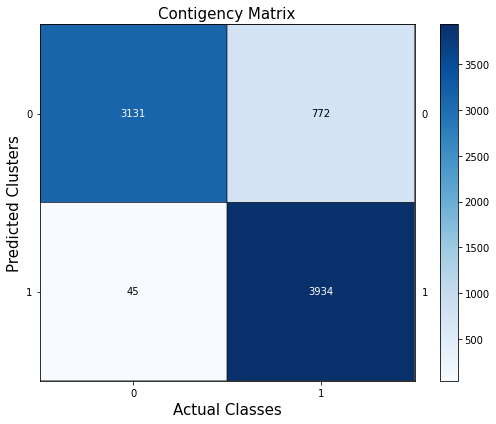

In [ ]:
km_measures, _ = report_KM_clustering_measures(tfidf_matrix, y_binary)

### Report 5 Measures of K Means

In [ ]:
km_measures

Homogeneity: 		 0.572286669402203
Completeness: 		 0.5883415696007297
V-measure:    		 0.580203076269998
Adjusted Rand: 		 0.6283142568971879
Adjusted mutual info: 	 0.5801641116732054


## Clustering with Dense Text Representations

### Generate dense representations for better K-means Clustering

#### Plot explained_variance_ratio

In [ ]:
svd = TruncatedSVD(n_components=1000)
svd_reducted_matrix = svd.fit_transform(tfidf_matrix)

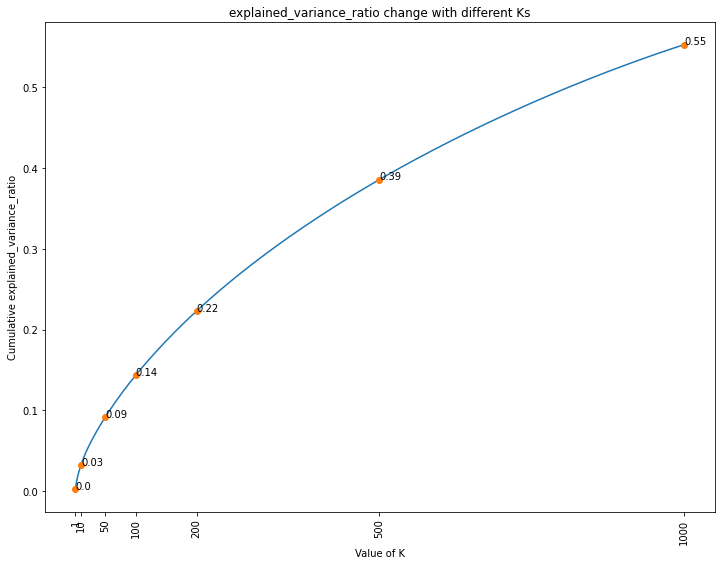

In [ ]:
cumulative_evr = np.cumsum(svd.explained_variance_ratio_[:1000])
Ks = [1, 10, 50, 100, 200, 500, 1000]
markers = [cumulative_evr[k - 1] for k in Ks]
plt.figure(figsize=(12,9))
plt.plot(range(1, 1001), cumulative_evr)
plt.plot(Ks, markers, ls="", marker="o", label="points")
for K, evr in zip(Ks, markers):
  plt.text(K, evr, str(round(evr, 2)))
plt.title('explained_variance_ratio change with different Ks')
plt.xlabel("Value of K")
plt.ylabel("Cumulative explained_variance_ratio")
plt.xticks(Ks, rotation = 90)
plt.show() 

#### Compare TruncatedSVD and NMF

In [ ]:
def report_dimension_reduction(model_name, X, y_true, Ks, results):
  for k in Ks:
    print("==== n_components: {} ====".format(k))
    model = TruncatedSVD(n_components=k) if model_name == 'SVD' else NMF(n_components=k)
    transformed_X = model.fit_transform(X)
    measure_result, _ = report_KM_clustering_measures(transformed_X, y_true)
    results["homogeneity"].append(measure_result["homogeneity"])
    results["completeness"].append(measure_result["completeness"])
    results["v_measure"].append(measure_result["v_measure"])
    results["adjusted_rand_index"].append(measure_result["adjusted_rand_index"])
    results["adjusted_mutual_info"].append(measure_result["adjusted_mutual_info"])

def plot_measure_results_based_on_Ks(results_based_on_Ks, Ks, model_name):
  results_df = pd.DataFrame(
      data = results_based_on_Ks,
      index = Ks
  )

  results_df.plot(
      kind = 'bar',
      title = "{}: Measure Scores Based on Different Ks".format(model_name), 
      xlabel = "Different Ks",
      ylabel = "The Measure Score",
      figsize = (12, 7)
  )

In [ ]:
Ks = [1, 2, 3, 5, 10, 20, 50, 100, 300]
svd_results_based_on_Ks = {
    "homogeneity": [],
    "completeness": [],
    "v_measure": [],
    "adjusted_rand_index": [],
    "adjusted_mutual_info": []
}

nmf_results_based_on_Ks = {
    "homogeneity": [],
    "completeness": [],
    "v_measure": [],
    "adjusted_rand_index": [],
    "adjusted_mutual_info": []
}

==== n_components: 1 ====
Homogeneity: 		 0.019034591198472048
Completeness: 		 0.019360460836506627
V-measure:    		 0.01919614314371571
Adjusted Rand: 		 0.02600277723478506
Adjusted mutual info: 	 0.019105587560509656


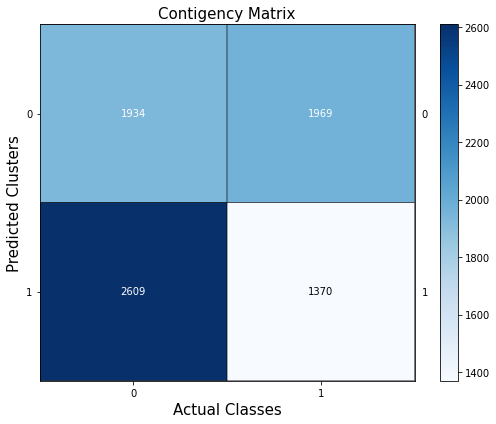

==== n_components: 2 ====
Homogeneity: 		 0.5290568591667052
Completeness: 		 0.5466431001230201
V-measure:    		 0.5377062240054288
Adjusted Rand: 		 0.585225410661106
Adjusted mutual info: 	 0.5376632083842694


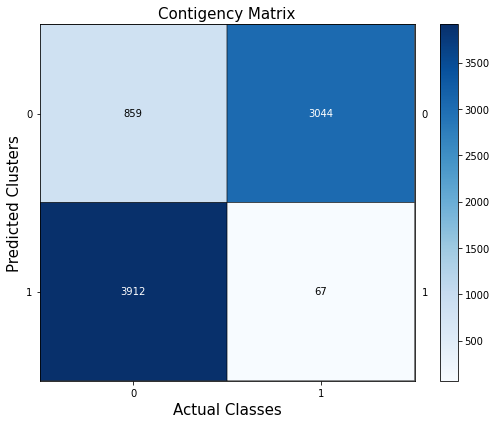

==== n_components: 3 ====
Homogeneity: 		 0.5371734232677687
Completeness: 		 0.5538835603967028
V-measure:    		 0.5454005293669162
Adjusted Rand: 		 0.5953645055833544
Adjusted mutual info: 	 0.545358272720199


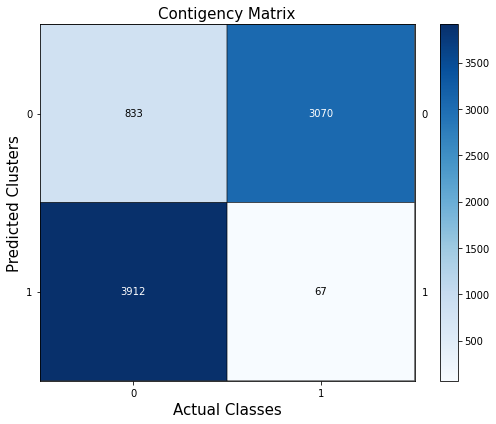

==== n_components: 5 ====
Homogeneity: 		 0.5185201977032754
Completeness: 		 0.5410997508442511
V-measure:    		 0.5295693992351633
Adjusted Rand: 		 0.5598788041448911
Adjusted mutual info: 	 0.5295254126753022


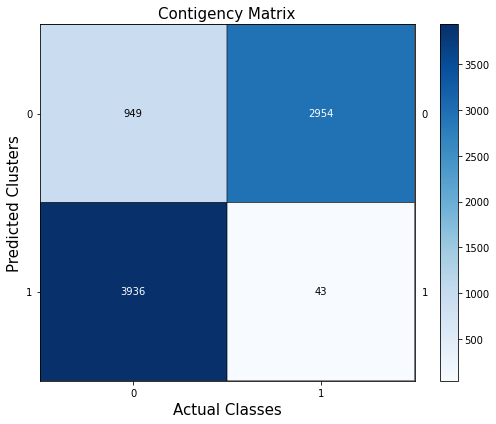

==== n_components: 10 ====
Homogeneity: 		 0.551248382432788
Completeness: 		 0.5676941649771408
V-measure:    		 0.5593504168459048
Adjusted Rand: 		 0.608754713186364
Adjusted mutual info: 	 0.5593094818408894


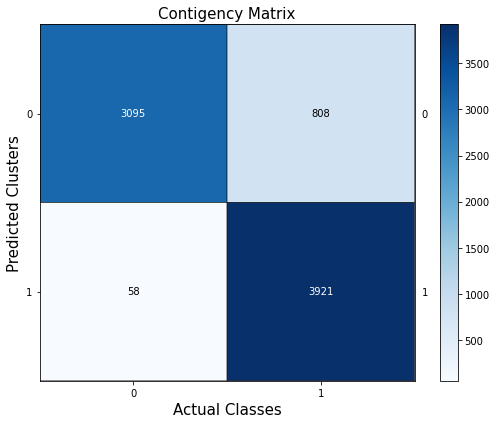

==== n_components: 20 ====
Homogeneity: 		 0.560122769102265
Completeness: 		 0.5760502685172075
V-measure:    		 0.5679748785801175
Adjusted Rand: 		 0.6182962526220315
Adjusted mutual info: 	 0.5679347716422906


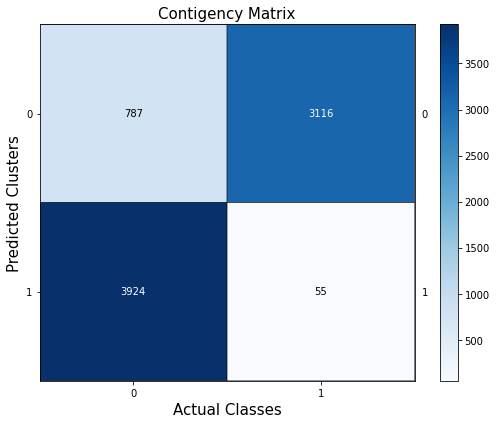

==== n_components: 50 ====
Homogeneity: 		 0.5709341170708413
Completeness: 		 0.585760192886905
V-measure:    		 0.5782521374266074
Adjusted Rand: 		 0.6315369863519584
Adjusted mutual info: 	 0.5782130309835184


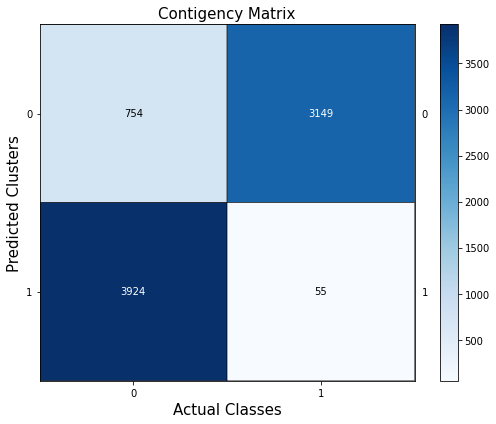

==== n_components: 100 ====
Homogeneity: 		 0.5761730731883462
Completeness: 		 0.5902263488274636
V-measure:    		 0.583115051091044
Adjusted Rand: 		 0.6388183153570486
Adjusted mutual info: 	 0.5830764249421082


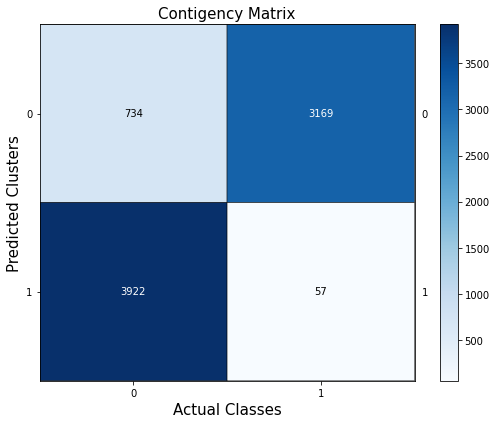

==== n_components: 300 ====
Homogeneity: 		 0.5759685021599601
Completeness: 		 0.5904259148484542
V-measure:    		 0.5831076089748379
Adjusted Rand: 		 0.6371966419064615
Adjusted mutual info: 	 0.5830689688991706


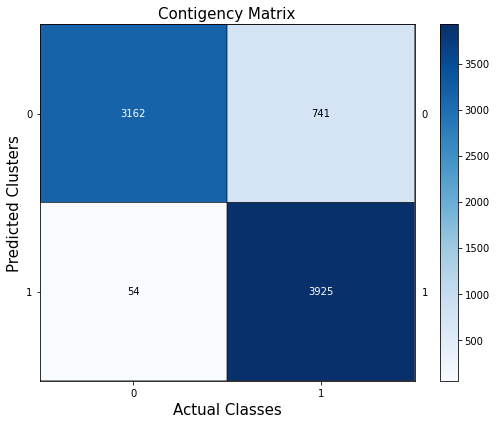

In [ ]:
report_dimension_reduction(
    'SVD', 
    tfidf_matrix, 
    y_binary, 
    Ks, 
    svd_results_based_on_Ks
)

==== n_components: 1 ====


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Homogeneity: 		 0.019034591198472048
Completeness: 		 0.019360460836506627
V-measure:    		 0.01919614314371571
Adjusted Rand: 		 0.02600277723478506
Adjusted mutual info: 	 0.019105587560509656


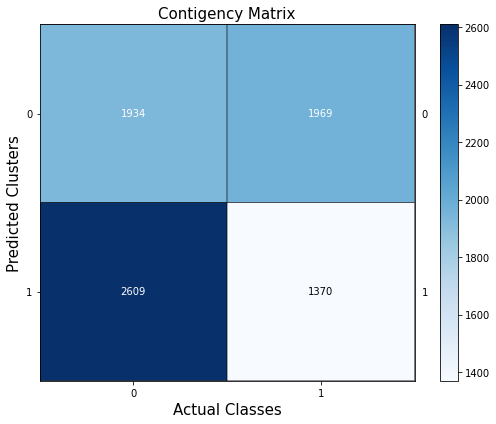

==== n_components: 2 ====


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Homogeneity: 		 0.5929642880687599
Completeness: 		 0.5944112969629405
V-measure:    		 0.5936869108088461
Adjusted Rand: 		 0.6972989285237455
Adjusted mutual info: 	 0.593649667363559


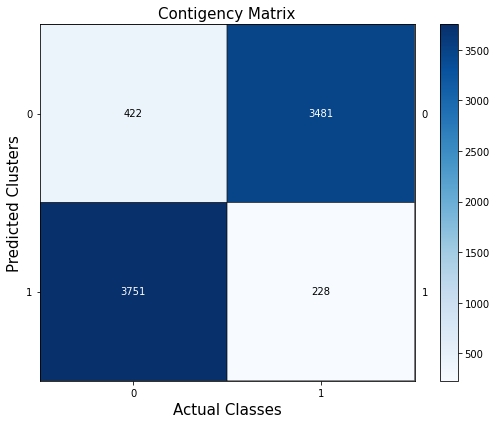

==== n_components: 3 ====


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Homogeneity: 		 0.5719647685026925
Completeness: 		 0.5749266623105384
V-measure:    		 0.5734418908009494
Adjusted Rand: 		 0.6725166723140447
Adjusted mutual info: 	 0.5734027383536082


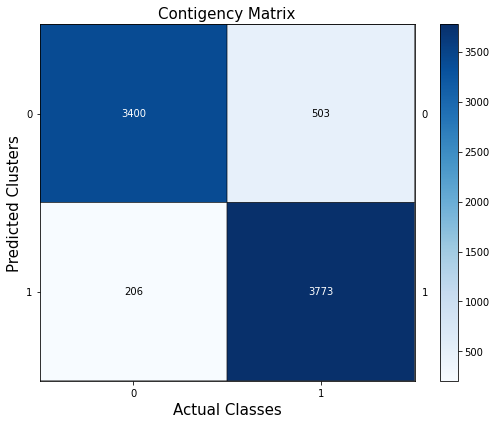

==== n_components: 5 ====


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Homogeneity: 		 0.25313353564741486
Completeness: 		 0.32710142176810103
V-measure:    		 0.2854027953650541
Adjusted Rand: 		 0.20390558097904946
Adjusted mutual info: 	 0.2853290251330515


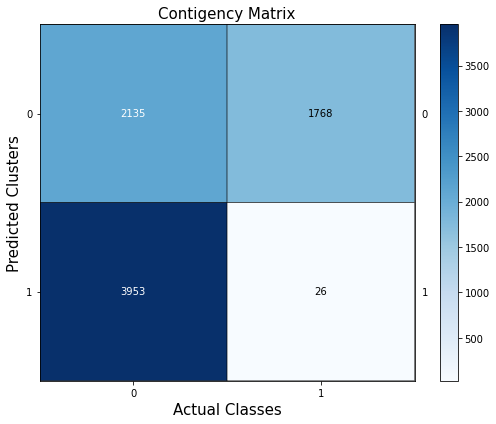

==== n_components: 10 ====


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Homogeneity: 		 0.17426579850960813
Completeness: 		 0.27329622116644475
V-measure:    		 0.2128249588546453
Adjusted Rand: 		 0.1067122611208701
Adjusted mutual info: 	 0.21273692622565896


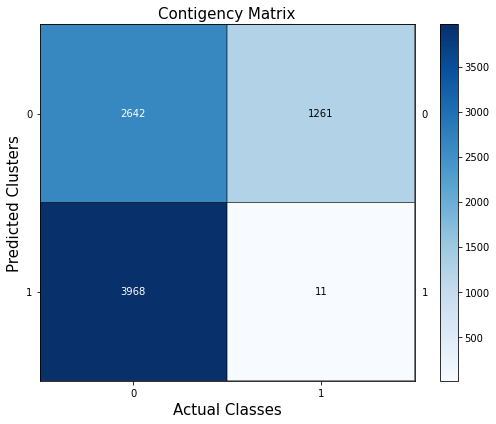

==== n_components: 20 ====


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Homogeneity: 		 0.4647492387073879
Completeness: 		 0.4848968685766169
V-measure:    		 0.474609328241438
Adjusted Rand: 		 0.5174193343663865
Adjusted mutual info: 	 0.47456020724859416


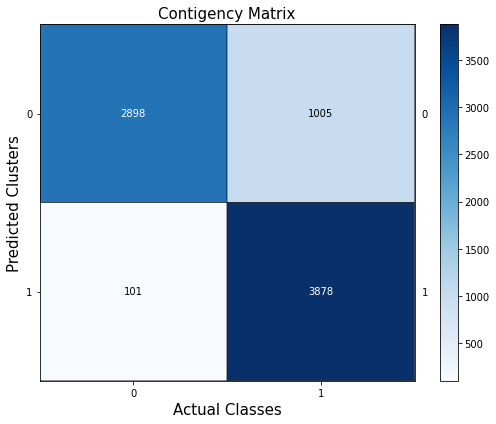

==== n_components: 50 ====


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Homogeneity: 		 0.03397274200642485
Completeness: 		 0.15601298406852074
V-measure:    		 0.05579565335683699
Adjusted Rand: 		 0.006010916167902848
Adjusted mutual info: 	 0.055653441752563176


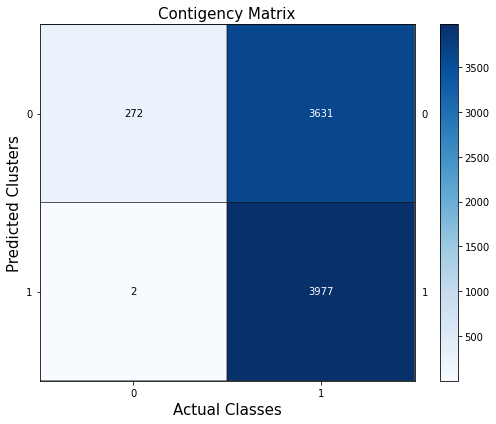

==== n_components: 100 ====


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Homogeneity: 		 0.0012877195572840966
Completeness: 		 0.09172942657306844
V-measure:    		 0.002539785007186998
Adjusted Rand: 		 5.5204716378877675e-05
Adjusted mutual info: 	 0.002348793290681006


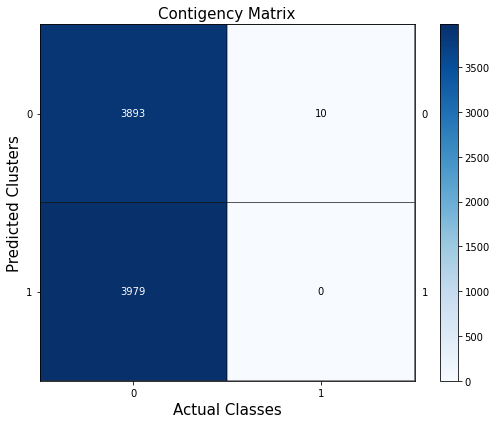

==== n_components: 300 ====


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Homogeneity: 		 0.001674498463656584
Completeness: 		 0.09500740895112796
V-measure:    		 0.0032909934149753573
Adjusted Rand: 		 7.427748321653377e-05
Adjusted mutual info: 	 0.0031038259314006282


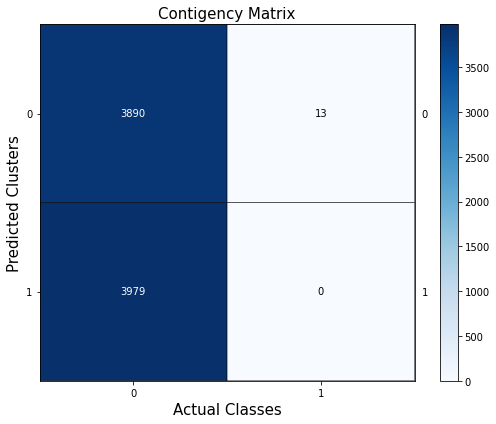

In [ ]:
report_dimension_reduction(
    'NMF', 
    tfidf_matrix, 
    y_binary, 
    Ks, 
    nmf_results_based_on_Ks
)

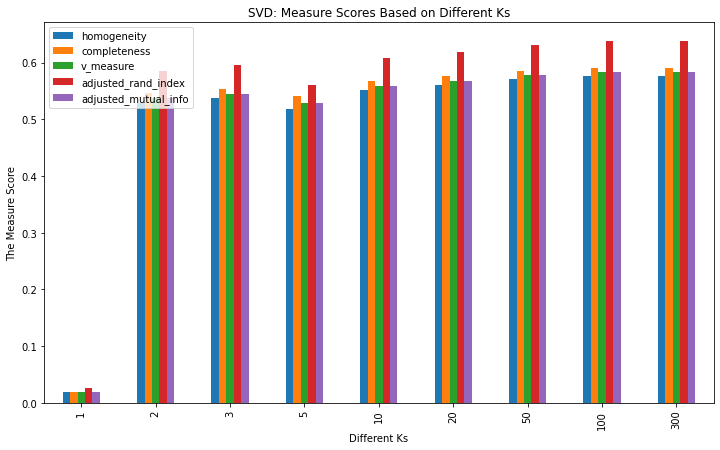

In [ ]:
plot_measure_results_based_on_Ks(svd_results_based_on_Ks, Ks, "SVD")

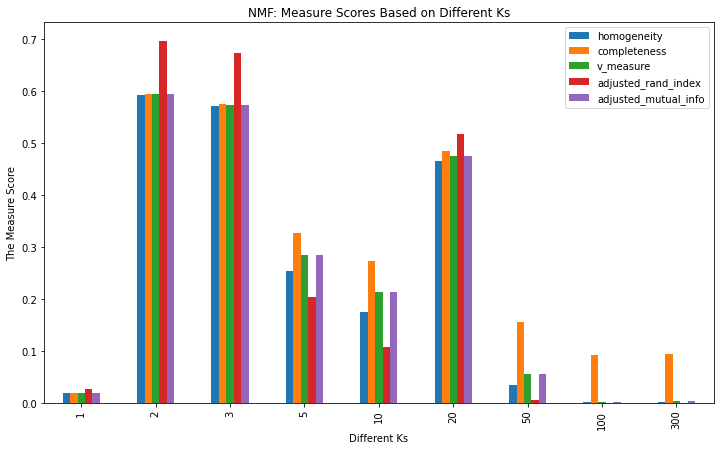

In [ ]:
plot_measure_results_based_on_Ks(nmf_results_based_on_Ks, Ks, "NMF")

#### Average of Measure Scores for SVD and NMF

In [ ]:
svd_means = [np.mean(scores) for measure, scores in svd_results_based_on_Ks.items()]
nmf_means = [np.mean(scores) for measure, scores in nmf_results_based_on_Ks.items()]
nmf_means < list(km_measures.values()) > svd_means

True

### Visualize the Clusters

In [ ]:
def plot_truth_and_prediction_clusters(km, prediction, truth, model_name):

  fig = plt.figure(figsize=(12, 6))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)
  if np.mean(km.labels_ == truth) > 0.5:
    predicted_labels = km.labels_
  else:
    predicted_labels = [1-x for x in km.labels_]
  ax1.scatter(
      x = prediction[: ,0],
      y = prediction[: ,1],
      c = predicted_labels, 
      edgecolors='k', 
      linewidth=0.25,  
      cmap='cool', 
      alpha=0.5
  )
  ax1.set_title("Prediction")

  ax2.scatter(
      x = prediction[: ,0],
      y = prediction[: ,1],
      c = truth,
      edgecolors='k', 
      linewidth=0.25,  
      cmap='cool', 
      alpha=0.5
  )
  ax2.set_title("Ground Truth")
  fig.suptitle("Best {} Visualization".format(model_name))
  plt.show()

#### Visualization for Best SVD

Homogeneity: 		 0.5776397225095417
Completeness: 		 0.5919331279018905
V-measure:    		 0.5846990850123975
Adjusted Rand: 		 0.6392240641895892
Adjusted mutual info: 	 0.5846605990621068


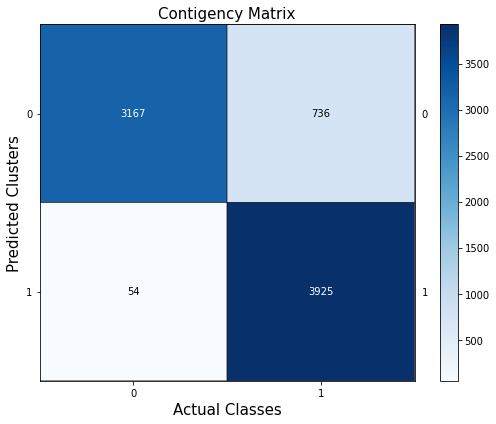

In [ ]:
best_svd = TruncatedSVD(n_components=100)
best_transformed_X_svd = best_svd.fit_transform(tfidf_matrix)
best_measure_result_svd, best_km_svd = report_KM_clustering_measures(best_transformed_X_svd, y_binary)

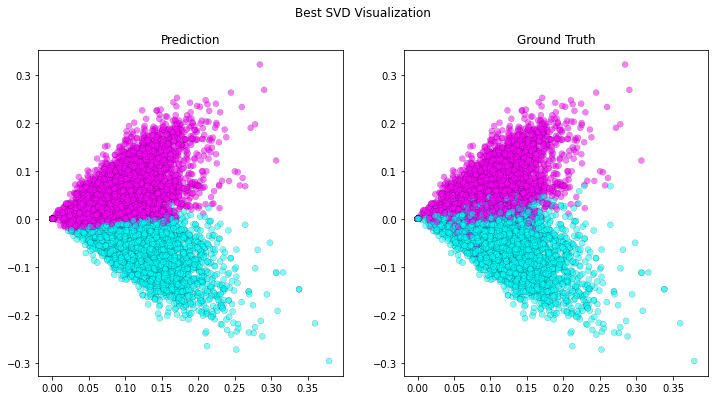

In [ ]:
plot_truth_and_prediction_clusters(best_km_svd, best_transformed_X_svd, y_binary, "SVD")

#### Visualization for Best NMF

Homogeneity: 		 0.5929642880687599
Completeness: 		 0.5944112969629405
V-measure:    		 0.5936869108088461
Adjusted Rand: 		 0.6972989285237455
Adjusted mutual info: 	 0.593649667363559


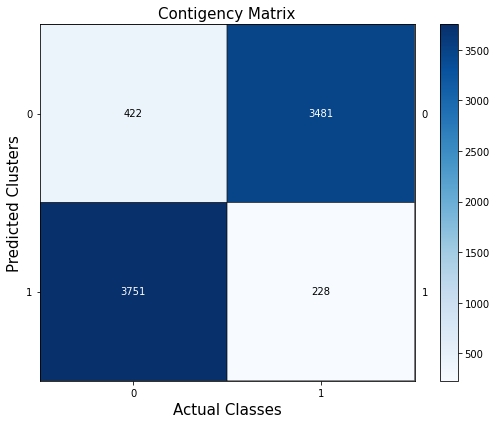

In [ ]:
# best_nmf = NMF(n_components=2, init='random')
best_nmf = NMF(n_components=2, random_state=0, init='nndsvd')
best_transformed_X_nmf = best_nmf.fit_transform(tfidf_matrix)
best_measure_result_nmf, best_km_nmf = report_KM_clustering_measures(best_transformed_X_nmf, y_binary)

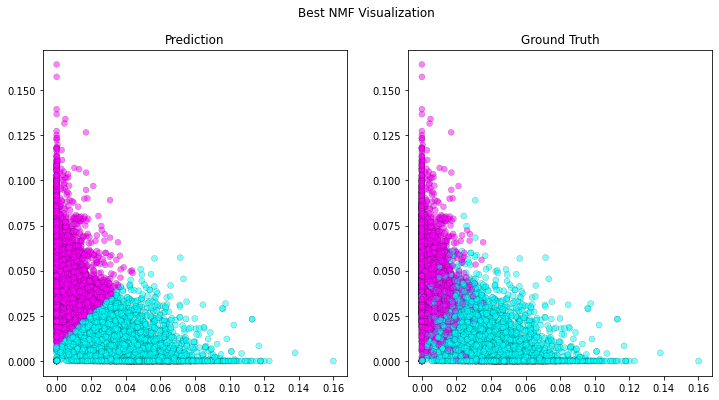

In [ ]:
plot_truth_and_prediction_clusters(best_km_nmf, best_transformed_X_nmf, y_binary, "NMF")

In [ ]:
sum(best_km_nmf.labels_ == y_binary) / len(y_binary)

0.08246637909160112

### Clustering of the Entire 20 Classes

#### Get TF-IDF Matrix

In [ ]:
dataset_20_cate = fetch_20newsgroups(
    subset='all',  
    shuffle=True, 
    random_state=42,
    remove=('headers', 'footers')
)

In [ ]:
count_vect = CountVectorizer(min_df=3, stop_words='english')
X_counts_20_cate = count_vect.fit_transform(dataset_20_cate.data)
tfidf = TfidfTransformer()
tfidf_matrix_20_cate = tfidf.fit_transform(X_counts_20_cate)

#### Report Measure Score without Dimensionality Reduction 

In [ ]:
y_20_cate = [t for t in dataset_20_cate.target]

In [ ]:
km_20_cate_wo_dr = KMeans(
    n_clusters=20,
    random_state=0,
    max_iter=1000,
    n_init=30
)
y_pred_20_wo_dr = km_20_cate_wo_dr.fit_predict(tfidf_matrix_20_cate)

In [ ]:
con_mat_20_cate_wo_dr = contingency_matrix(y_20_cate, y_pred_20_wo_dr)
homogeneity_20_cate_wo_dr = metrics.homogeneity_score(y_20_cate,y_pred_20_wo_dr)
completeness_20_cate_wo_dr = metrics.completeness_score(y_20_cate,y_pred_20_wo_dr)
v_measure_20_cate_wo_dr = metrics.v_measure_score(y_20_cate,y_pred_20_wo_dr)
adjusted_rand_index_20_cate_wo_dr = metrics.adjusted_rand_score(y_20_cate,y_pred_20_wo_dr)
adjusted_mutual_info_20_cate_wo_dr = metrics.adjusted_mutual_info_score(y_20_cate,y_pred_20_wo_dr)

print("Homogeneity: \t\t", homogeneity_20_cate_wo_dr)
print("Completeness: \t\t", completeness_20_cate_wo_dr)
print("V-measure:    \t\t", v_measure_20_cate_wo_dr)
print("Adjusted Rand: \t\t", adjusted_rand_index_20_cate_wo_dr)
print("Adjusted mutual info: \t", adjusted_mutual_info_20_cate_wo_dr)

Homogeneity: 		 0.34790859768457
Completeness: 		 0.39677714833899
V-measure:    		 0.37073942131701093
Adjusted Rand: 		 0.12210793219608113
Adjusted mutual info: 	 0.36856401463430694


#### Reduce Dimension Using NMF

In [ ]:
def nmf_best_n_components(model_name,X,label,n_components_list,results):
  for n_components in n_components_list:
    print("==== n_components: {} ====".format(n_components))
    nmf_20_cate = NMF(n_components=n_components, random_state=0, init='nndsvd')
    transformed_X_nmf_20_cate = nmf_20_cate.fit_transform(X)

    y_pred_20 = model_name.fit_predict(transformed_X_nmf_20_cate)
    con_mat_20_cate = contingency_matrix(label, y_pred_20)

    homogeneity_20_cate = metrics.homogeneity_score(label,y_pred_20)
    completeness_20_cate = metrics.completeness_score(label,y_pred_20)
    v_measure_20_cate = metrics.v_measure_score(label,y_pred_20)
    adjusted_rand_index_20_cate = metrics.adjusted_rand_score(label,y_pred_20)
    adjusted_mutual_info_20_cate = metrics.adjusted_mutual_info_score(label,y_pred_20)

    results["homogeneity"].append(homogeneity_20_cate)
    results["completeness"].append(completeness_20_cate)
    results["v_measure"].append(v_measure_20_cate)
    results["adjusted_rand_index"].append(adjusted_rand_index_20_cate)
    results["adjusted_mutual_info"].append(adjusted_mutual_info_20_cate)

    print("Homogeneity: \t\t", homogeneity_20_cate)
    print("Completeness: \t\t", completeness_20_cate)
    print("V-measure:    \t\t", v_measure_20_cate)
    print("Adjusted Rand: \t\t", adjusted_rand_index_20_cate)
    print("Adjusted mutual info: \t", adjusted_mutual_info_20_cate)

In [ ]:
y_20_cate = [t for t in dataset_20_cate.target]

#### Report Measure Score of K-Means using NMF (20 categories)

In [ ]:
km_20_cate = KMeans(
    n_clusters=20,
    random_state=0,
    max_iter=1000,
    n_init=30
)

results_km_20_cate_nmf = {
    "homogeneity": [],
    "completeness": [],
    "v_measure": [],
    "adjusted_rand_index": [],
    "adjusted_mutual_info": []
}
n_components_list = [5,20,100,200]

In [ ]:
nmf_best_n_components(km_20_cate,tfidf_matrix_20_cate,y_20_cate,n_components_list,results_km_20_cate_nmf)

==== n_components: 5 ====
Homogeneity: 		 0.26968243804071834
Completeness: 		 0.32136572364263605
V-measure:    		 0.29326439865012643
Adjusted Rand: 		 0.0884926868130358
Adjusted mutual info: 	 0.2907395776701989
==== n_components: 20 ====
Homogeneity: 		 0.30042425377800314
Completeness: 		 0.37001569891565955
V-measure:    		 0.33160819186345625
Adjusted Rand: 		 0.07850776564026335
Adjusted mutual info: 	 0.32921095670738
==== n_components: 100 ====
Homogeneity: 		 0.11900103421825037
Completeness: 		 0.22959167797881114
V-measure:    		 0.1567539777592191
Adjusted Rand: 		 0.009412985765156654
Adjusted mutual info: 	 0.15307504396110058
==== n_components: 200 ====


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Homogeneity: 		 0.09300707905656351
Completeness: 		 0.24068721045562563
V-measure:    		 0.13416839972583597
Adjusted Rand: 		 0.006508541764241407
Adjusted mutual info: 	 0.12991504536300102


#### Reduce Dimension Using SVD

In [ ]:
def svd_best_n_components(model_name,X,label,n_components_list,results):
  for n_components in n_components_list:
    print("==== n_components: {} ====".format(n_components))
    svd_20_cate = TruncatedSVD(n_components=n_components)
    transformed_X_svd_20_cate = svd_20_cate.fit_transform(X)

    y_pred_20 = model_name.fit_predict(transformed_X_svd_20_cate)
    con_mat_20_cate = contingency_matrix(label, y_pred_20)

    homogeneity_20_cate = metrics.homogeneity_score(label,y_pred_20)
    completeness_20_cate = metrics.completeness_score(label,y_pred_20)
    v_measure_20_cate = metrics.v_measure_score(label,y_pred_20)
    adjusted_rand_index_20_cate = metrics.adjusted_rand_score(label,y_pred_20)
    adjusted_mutual_info_20_cate = metrics.adjusted_mutual_info_score(label,y_pred_20)

    results["homogeneity"].append(homogeneity_20_cate)
    results["completeness"].append(completeness_20_cate)
    results["v_measure"].append(v_measure_20_cate)
    results["adjusted_rand_index"].append(adjusted_rand_index_20_cate)
    results["adjusted_mutual_info"].append(adjusted_mutual_info_20_cate)

    print("Homogeneity: \t\t", homogeneity_20_cate)
    print("Completeness: \t\t", completeness_20_cate)
    print("V-measure:    \t\t", v_measure_20_cate)
    print("Adjusted Rand: \t\t", adjusted_rand_index_20_cate)
    print("Adjusted mutual info: \t", adjusted_mutual_info_20_cate)

In [ ]:
y_20_cate = [t for t in dataset_20_cate.target]

#### Report Measure Score of K-Means using SVD (20 categories)

In [ ]:
km_20_cate = KMeans(
    n_clusters=20,
    random_state=0,
    max_iter=1000,
    n_init=30
)

results_km_20_cate_svd = {
    "homogeneity": [],
    "completeness": [],
    "v_measure": [],
    "adjusted_rand_index": [],
    "adjusted_mutual_info": []
}
n_components_list = [5,20,100,200]

In [ ]:
svd_best_n_components(km_20_cate,tfidf_matrix_20_cate,y_20_cate,n_components_list,results_km_20_cate_svd)

==== n_components: 5 ====
Homogeneity: 		 0.32467718611007096
Completeness: 		 0.35279326312000675
V-measure:    		 0.33815179415890084
Adjusted Rand: 		 0.12839451940791383
Adjusted mutual info: 	 0.3359186292650956
==== n_components: 20 ====
Homogeneity: 		 0.32203003750180664
Completeness: 		 0.36925763276468926
V-measure:    		 0.3440305807311734
Adjusted Rand: 		 0.10456513767905536
Adjusted mutual info: 	 0.34175927413275015
==== n_components: 100 ====
Homogeneity: 		 0.35213081962046117
Completeness: 		 0.4334267387430322
V-measure:    		 0.3885721959749402
Adjusted Rand: 		 0.11948852937487153
Adjusted mutual info: 	 0.3863690421217935
==== n_components: 200 ====
Homogeneity: 		 0.31632490981493006
Completeness: 		 0.4074222375789923
V-measure:    		 0.35614040904433697
Adjusted Rand: 		 0.09276539932106924
Adjusted mutual info: 	 0.3537741974913982


Best SVD n_components: 100

In [ ]:
svd_20_cate_best = TruncatedSVD(n_components=100)
transformed_X_svd_20_cate_best = svd_20_cate_best.fit_transform(tfidf_matrix_20_cate)
y_pred_20_svd = km_20_cate.fit_predict(transformed_X_svd_20_cate_best)

In [ ]:
con_mat_20_cate_svd = contingency_matrix(y_20_cate, y_pred_20_svd)

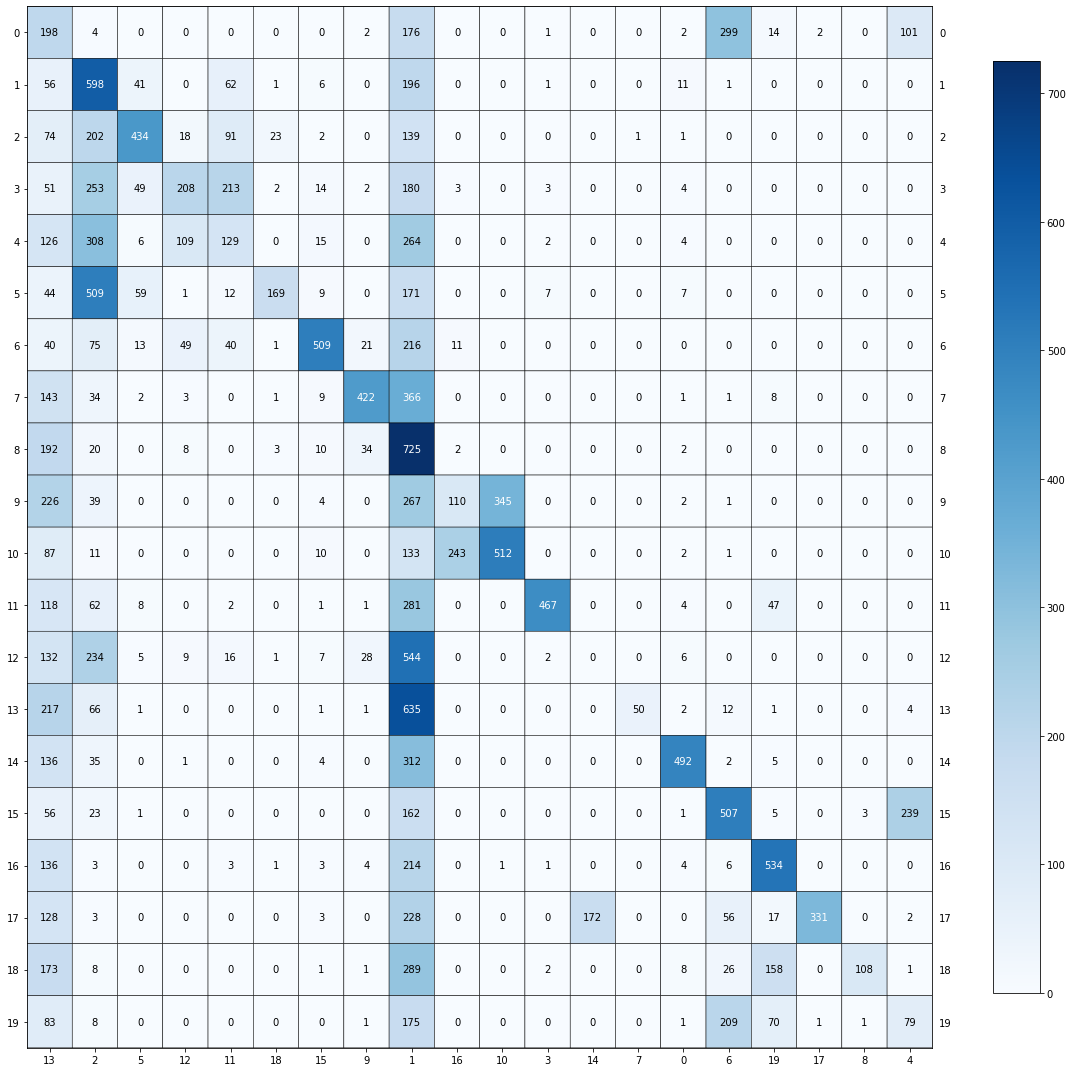

In [ ]:
rows, cols = linear_sum_assignment(con_mat_20_cate_svd, maximize=True)
plot_mat(con_mat_20_cate_svd[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

### UMAP of the Entire 20 Classes

#### Function Definition & Variables

In [ ]:
def umap_best_n_components(model_name,X,label,metric,n_components_list,results):
  for n_components in n_components_list:
    print("==== n_components: {} ====".format(n_components))
    umap_ = umap.UMAP(n_components=n_components, metric= metric) 
    umap_embedding = umap_.fit_transform(X)

    y_pred_20_umap = model_name.fit_predict(umap_embedding)
    con_mat_20_cate_umap = contingency_matrix(label, y_pred_20_umap)
    homogeneity_20_cate_umap = metrics.homogeneity_score(label,y_pred_20_umap)
    completeness_20_cate_umap = metrics.completeness_score(label,y_pred_20_umap)
    v_measure_20_cate_umap = metrics.v_measure_score(label,y_pred_20_umap)
    adjusted_rand_index_20_cate_umap = metrics.adjusted_rand_score(label,y_pred_20_umap)
    adjusted_mutual_info_20_cate_umap = metrics.adjusted_mutual_info_score(label,y_pred_20_umap)

    results["homogeneity"].append(homogeneity_20_cate_umap)
    results["completeness"].append(completeness_20_cate_umap)
    results["v_measure"].append(v_measure_20_cate_umap)
    results["adjusted_rand_index"].append(adjusted_rand_index_20_cate_umap)
    results["adjusted_mutual_info"].append(adjusted_mutual_info_20_cate_umap)
    print("Homogeneity: \t\t", homogeneity_20_cate_umap)
    print("Completeness: \t\t", completeness_20_cate_umap)
    print("V-measure:    \t\t", v_measure_20_cate_umap)
    print("Adjusted Rand: \t\t", adjusted_rand_index_20_cate_umap)
    print("Adjusted mutual info: \t", adjusted_mutual_info_20_cate_umap)

def km_best_k(X,label,n_components,metric,k_list,results):
  for k in k_list:
    print("==== k = {} ====".format(k))
    km_20_cate_k = KMeans(
        n_clusters=k,
        random_state=0,
        max_iter=1000,
        n_init=30)
    umap_ = umap.UMAP(n_components=n_components, metric= metric) 
    umap_embedding = umap_.fit_transform(X)

    y_pred_20_umap = km_20_cate_k.fit_predict(umap_embedding)
    con_mat_20_cate_umap = contingency_matrix(label, y_pred_20_umap)
    homogeneity_20_cate_umap = metrics.homogeneity_score(label,y_pred_20_umap)
    completeness_20_cate_umap = metrics.completeness_score(label,y_pred_20_umap)
    v_measure_20_cate_umap = metrics.v_measure_score(label,y_pred_20_umap)
    adjusted_rand_index_20_cate_umap = metrics.adjusted_rand_score(label,y_pred_20_umap)
    adjusted_mutual_info_20_cate_umap = metrics.adjusted_mutual_info_score(label,y_pred_20_umap)

    results["homogeneity"].append(homogeneity_20_cate_umap)
    results["completeness"].append(completeness_20_cate_umap)
    results["v_measure"].append(v_measure_20_cate_umap)
    results["adjusted_rand_index"].append(adjusted_rand_index_20_cate_umap)
    results["adjusted_mutual_info"].append(adjusted_mutual_info_20_cate_umap)
    print("Homogeneity: \t\t", homogeneity_20_cate_umap)
    print("Completeness: \t\t", completeness_20_cate_umap)
    print("V-measure:    \t\t", v_measure_20_cate_umap)
    print("Adjusted Rand: \t\t", adjusted_rand_index_20_cate_umap)
    print("Adjusted mutual info: \t", adjusted_mutual_info_20_cate_umap)


In [ ]:
n_components_list = [5,20,200]

km_20_cate_umap = KMeans(
    n_clusters=20,
    random_state=0,
    max_iter=1000,
    n_init=30
)

#### UMAP Using Euclidean Distance

In [ ]:
tfidf_matrix_20_cate.shape

(18846, 45365)

In [ ]:
results_km_umap_euc = {
    "homogeneity": [],
    "completeness": [],
    "v_measure": [],
    "adjusted_rand_index": [],
    "adjusted_mutual_info": []
}

In [ ]:
# Choose the best n_components
umap_best_n_components(km_20_cate_umap,tfidf_matrix_20_cate,y_20_cate,'euclidean',n_components_list,results_km_umap_euc)

==== n_components: 5 ====


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Homogeneity: 		 0.01000012478335683
Completeness: 		 0.010777826875441106
V-measure:    		 0.010374421446128561
Adjusted Rand: 		 0.0016296507619408358
Adjusted mutual info: 	 0.007077890095935255
==== n_components: 20 ====
Homogeneity: 		 0.010769160820139678
Completeness: 		 0.011583480571548786
V-measure:    		 0.011161487624308858
Adjusted Rand: 		 0.001409146474814078
Adjusted mutual info: 	 0.007870434974262288
==== n_components: 200 ====
Homogeneity: 		 0.007232250179959192
Completeness: 		 0.0076771208546437385
V-measure:    		 0.007448048419172545
Adjusted Rand: 		 0.0014390199321171735
Adjusted mutual info: 	 0.004302396679702002


Best n_components for euclidean metric: 20

In [ ]:
# n_components = 20
umap_euc = umap.UMAP(n_components=20, metric='euclidean')
umap_euc_embedding = umap_euc.fit_transform(tfidf_matrix_20_cate)
y_pred_20_umap_euc = km_20_cate_umap.fit_predict(umap_euc_embedding)
con_mat_20_cate_umap_euc = contingency_matrix(y_20_cate, y_pred_20_umap_euc)

In [ ]:
# km_20_cate_umap_euc = KMeans(
#     n_clusters=20,
#     random_state=0,
#     max_iter=1000,
#     n_init=30
# )
# y_pred_20_umap_euc = km_20_cate_umap_euc.fit_predict(umap_euc_embedding)
# con_mat_20_cate_umap_euc = contingency_matrix(y_20_cate, y_pred_20_umap_euc)
# homogeneity_20_cate_umap_euc = metrics.homogeneity_score(y_20_cate,y_pred_20_umap_euc)
# completeness_20_cate_umap_euc = metrics.completeness_score(y_20_cate,y_pred_20_umap_euc)
# v_measure_20_cate_umap_euc = metrics.v_measure_score(y_20_cate,y_pred_20_umap_euc)
# adjusted_rand_index_20_cate_umap_euc = metrics.adjusted_rand_score(y_20_cate,y_pred_20_umap_euc)
# adjusted_mutual_info_20_cate_umap_euc = metrics.adjusted_mutual_info_score(y_20_cate,y_pred_20_umap_euc)

# print("Homogeneity: \t\t", homogeneity_20_cate_umap_euc)
# print("Completeness: \t\t", completeness_20_cate_umap_euc)
# print("V-measure:    \t\t", v_measure_20_cate_umap_euc)
# print("Adjusted Rand: \t\t", adjusted_rand_index_20_cate_umap_euc)
# print("Adjusted mutual info: \t", adjusted_mutual_info_20_cate_umap_euc)

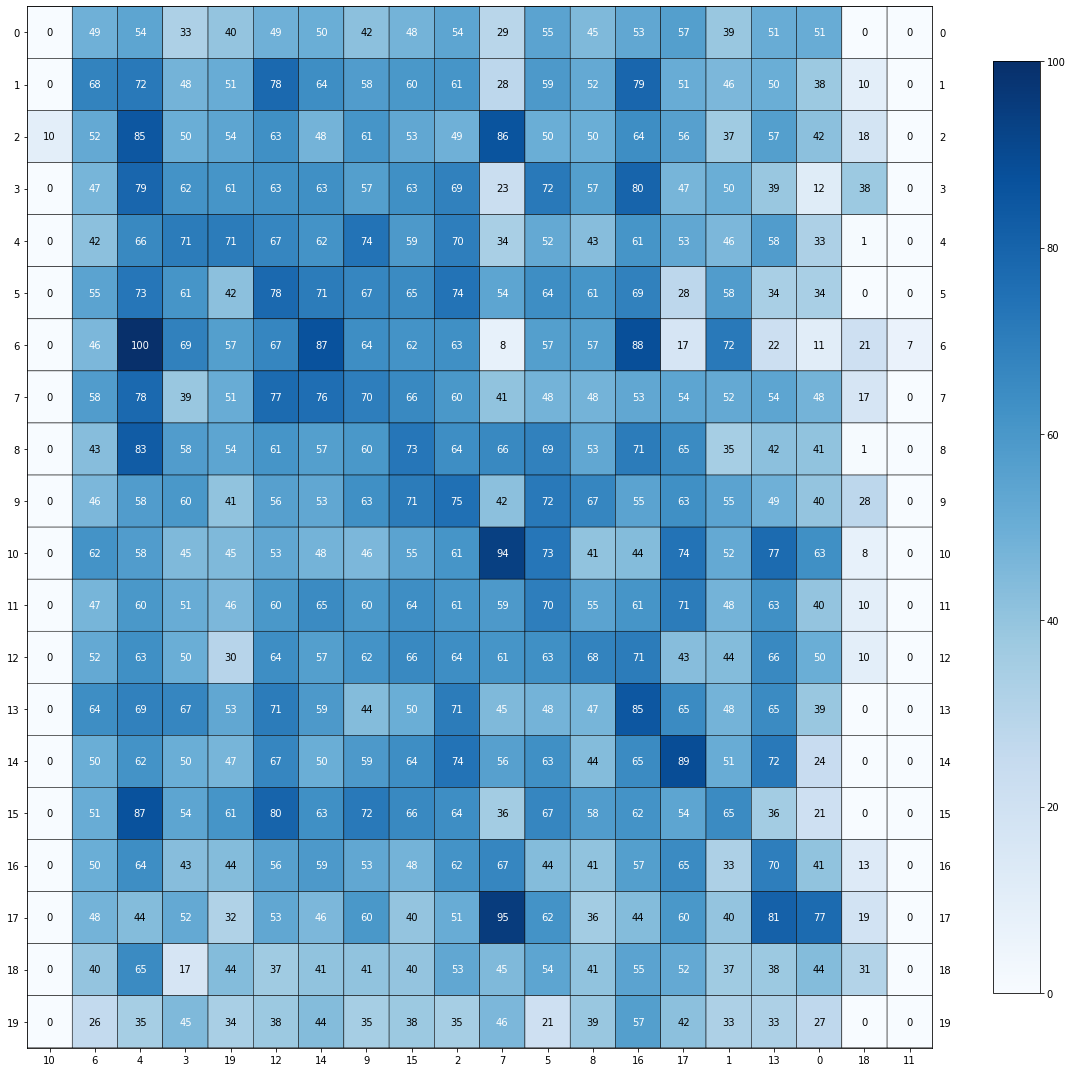

In [ ]:
rows, cols = linear_sum_assignment(con_mat_20_cate_umap_euc, maximize=True)
plot_mat(con_mat_20_cate_umap_euc[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

#### UMAP Using Cosine

In [ ]:
results_km_umap_cos = {
    "homogeneity": [],
    "completeness": [],
    "v_measure": [],
    "adjusted_rand_index": [],
    "adjusted_mutual_info": []
}

In [ ]:
# Choose the best n_components
umap_best_n_components(km_20_cate_umap,tfidf_matrix_20_cate,y_20_cate,'cosine',n_components_list,results_km_umap_cos)

==== n_components: 5 ====
Homogeneity: 		 0.5611270649073593
Completeness: 		 0.5796345993293621
V-measure:    		 0.570230700482139
Adjusted Rand: 		 0.4391848180501076
Adjusted mutual info: 	 0.5688089018119032
==== n_components: 20 ====
Homogeneity: 		 0.5629311494502759
Completeness: 		 0.5873873534964182
V-measure:    		 0.574899277424936
Adjusted Rand: 		 0.45065869176728857
Adjusted mutual info: 	 0.5734844834119995
==== n_components: 200 ====
Homogeneity: 		 0.5695623708583318
Completeness: 		 0.5958570228831612
V-measure:    		 0.5824130617157027
Adjusted Rand: 		 0.4484053805159569
Adjusted mutual info: 	 0.5810229819906624


Best n_components for cosine metric: 20

In [ ]:
# n_components = 20
umap_cos = umap.UMAP(n_components=20, metric='cosine')
umap_cos_embedding = umap_cos.fit_transform(tfidf_matrix_20_cate)
y_pred_20_umap_cos = km_20_cate_umap.fit_predict(umap_cos_embedding)
con_mat_20_cate_umap_cos = contingency_matrix(y_20_cate, y_pred_20_umap_cos)

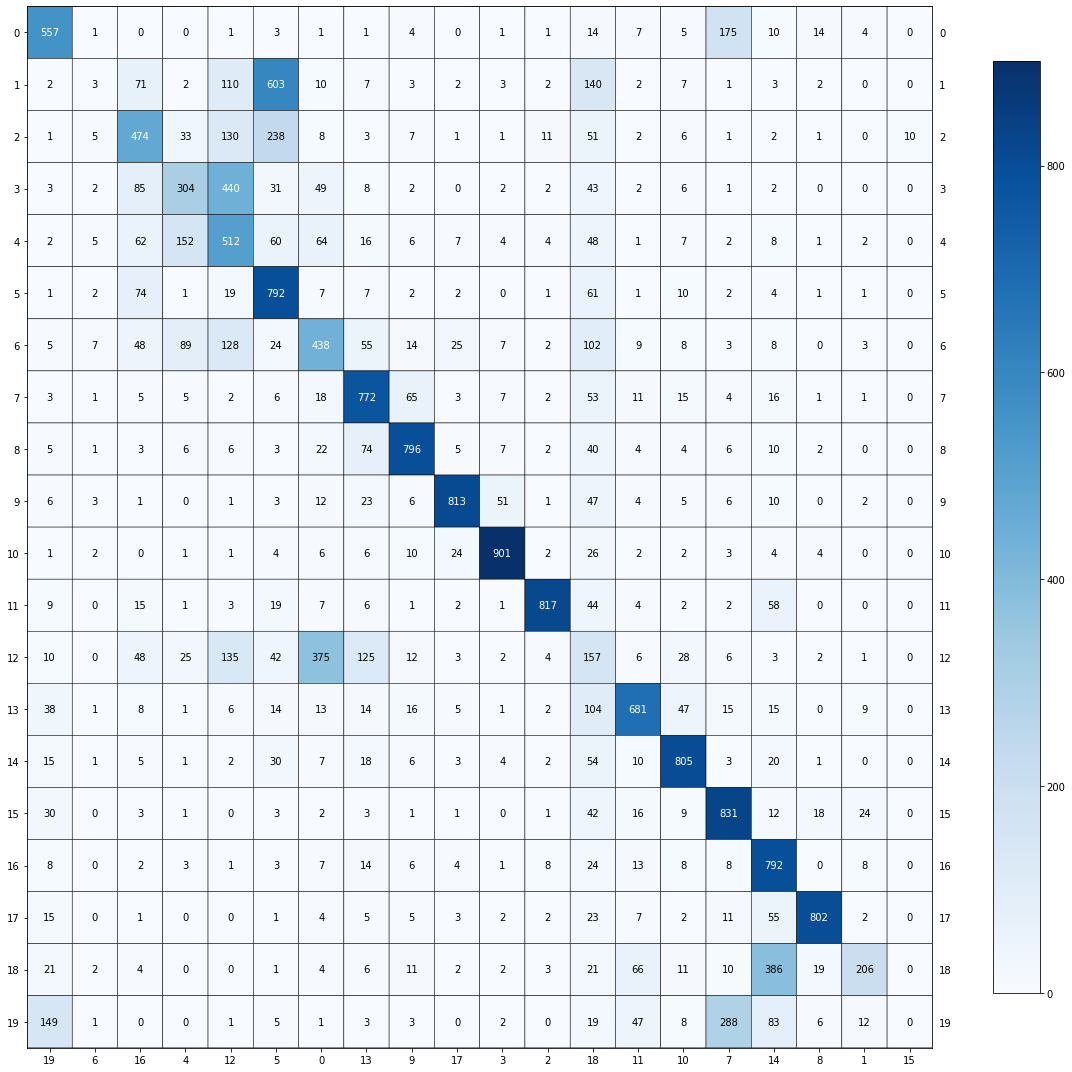

In [ ]:
rows, cols = linear_sum_assignment(con_mat_20_cate_umap_cos, maximize=True)
plot_mat(con_mat_20_cate_umap_cos[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

#### Select k for K-Means using UMAP


In [ ]:
results_km_umap_k = {
    "homogeneity": [],
    "completeness": [],
    "v_measure": [],
    "adjusted_rand_index": [],
    "adjusted_mutual_info": []
}
k_list = [10,20,50]

In [ ]:
# Choose the best k
km_best_k(tfidf_matrix_20_cate,y_20_cate,20,'cosine',k_list,results_km_umap_k)

==== k = 10 ====
Homogeneity: 		 0.4625000231758495
Completeness: 		 0.6577168144883633
V-measure:    		 0.5430984997124221
Adjusted Rand: 		 0.33488294207000235
Adjusted mutual info: 	 0.5422657167765588
==== k = 20 ====
Homogeneity: 		 0.5738007321585789
Completeness: 		 0.5955712951896976
V-measure:    		 0.5844833589998313
Adjusted Rand: 		 0.45914752663079744
Adjusted mutual info: 	 0.5831049527117814
==== k = 50 ====
Homogeneity: 		 0.6251530976207271
Completeness: 		 0.5043873357385285
V-measure:    		 0.5583143303685845
Adjusted Rand: 		 0.39285887584371676
Adjusted mutual info: 	 0.5549668514695405


## Clustering Algorithms that do not explicitly rely on the Gaussian distribution per cluster

### Agglomerative Clustering

#### UMAP Embedding

In [ ]:
umap_agg = umap.UMAP(n_components=20, metric='cosine')
umap_agg_embedding = umap_agg.fit_transform(tfidf_matrix_20_cate)

#### Ward Linkage Criteria

In [ ]:
# n_clusters = 20
agg_ward_20_cate_umap = AgglomerativeClustering(
    n_clusters= 20,
    linkage='ward'
)

In [ ]:
y_pred_20_agg_ward = agg_ward_20_cate_umap.fit_predict(umap_agg_embedding)
con_mat_20_cate_agg_ward = contingency_matrix(y_20_cate, y_pred_20_agg_ward)

In [ ]:
# five clustering evaluation metrics
homogeneity_20_cate_agg_ward = metrics.homogeneity_score(y_20_cate,y_pred_20_agg_ward)
completeness_20_cate_agg_ward= metrics.completeness_score(y_20_cate,y_pred_20_agg_ward)
v_measure_20_cate_agg_ward = metrics.v_measure_score(y_20_cate,y_pred_20_agg_ward)
adjusted_rand_index_20_cate_agg_ward = metrics.adjusted_rand_score(y_20_cate,y_pred_20_agg_ward)
adjusted_mutual_info_20_cate_agg_ward = metrics.adjusted_mutual_info_score(y_20_cate,y_pred_20_agg_ward)

print("Homogeneity: \t\t", homogeneity_20_cate_agg_ward)
print("Completeness: \t\t", completeness_20_cate_agg_ward)
print("V-measure:    \t\t", v_measure_20_cate_agg_ward)
print("Adjusted Rand: \t\t", adjusted_rand_index_20_cate_agg_ward)
print("Adjusted mutual info: \t", adjusted_mutual_info_20_cate_agg_ward)

Homogeneity: 		 0.559171437894619
Completeness: 		 0.5931374880726187
V-measure:    		 0.5756538626069768
Adjusted Rand: 		 0.43301259088929217
Adjusted mutual info: 	 0.5742292249253264


#### Singel Linkage Criteria

In [ ]:
# n_clusters = 20
agg_single_20_cate_umap = AgglomerativeClustering(
    n_clusters= 20,
    linkage='single'
)

In [ ]:
y_pred_20_agg_single = agg_single_20_cate_umap.fit_predict(umap_agg_embedding)
con_mat_20_cate_agg_single = contingency_matrix(y_20_cate, y_pred_20_agg_single)

In [ ]:
# five clustering evaluation metrics
homogeneity_20_cate_agg_single = metrics.homogeneity_score(y_20_cate,y_pred_20_agg_single)
completeness_20_cate_agg_single= metrics.completeness_score(y_20_cate,y_pred_20_agg_single)
v_measure_20_cate_agg_single = metrics.v_measure_score(y_20_cate,y_pred_20_agg_single)
adjusted_rand_index_20_cate_agg_single = metrics.adjusted_rand_score(y_20_cate,y_pred_20_agg_single)
adjusted_mutual_info_20_cate_agg_single = metrics.adjusted_mutual_info_score(y_20_cate,y_pred_20_agg_single)

print("Homogeneity: \t\t", homogeneity_20_cate_agg_single)
print("Completeness: \t\t", completeness_20_cate_agg_single)
print("V-measure:    \t\t", v_measure_20_cate_agg_single)
print("Adjusted Rand: \t\t", adjusted_rand_index_20_cate_agg_single)
print("Adjusted mutual info: \t", adjusted_mutual_info_20_cate_agg_single)

Homogeneity: 		 0.005462116819168942
Completeness: 		 0.23702279614125754
V-measure:    		 0.010678158781292099
Adjusted Rand: 		 9.375957767499856e-06
Adjusted mutual info: 	 0.005714325642047656


### DBSCAN and HDBSCAN

#### DBSCAN

In [ ]:
def dbscan_best_eps(umap_embedding,label,eps_list,results):
  for eps in eps_list:

    print("==== DBSCAN eps = {} ====".format(eps))

    dbscan_model = DBSCAN (eps = eps)
    y_pred_20_umap = dbscan_model.fit_predict(umap_embedding)
    con_mat_20_cate_umap = contingency_matrix(label, y_pred_20_umap)
    homogeneity_20_cate_umap = metrics.homogeneity_score(label,y_pred_20_umap)
    completeness_20_cate_umap = metrics.completeness_score(label,y_pred_20_umap)
    v_measure_20_cate_umap = metrics.v_measure_score(label,y_pred_20_umap)
    adjusted_rand_index_20_cate_umap = metrics.adjusted_rand_score(label,y_pred_20_umap)
    adjusted_mutual_info_20_cate_umap = metrics.adjusted_mutual_info_score(label,y_pred_20_umap)

    results["homogeneity"].append(homogeneity_20_cate_umap)
    results["completeness"].append(completeness_20_cate_umap)
    results["v_measure"].append(v_measure_20_cate_umap)
    results["adjusted_rand_index"].append(adjusted_rand_index_20_cate_umap)
    results["adjusted_mutual_info"].append(adjusted_mutual_info_20_cate_umap)
    print("Homogeneity: \t\t", homogeneity_20_cate_umap)
    print("Completeness: \t\t", completeness_20_cate_umap)
    print("V-measure:    \t\t", v_measure_20_cate_umap)
    print("Adjusted Rand: \t\t", adjusted_rand_index_20_cate_umap)
    print("Adjusted mutual info: \t", adjusted_mutual_info_20_cate_umap)

In [ ]:
umap_dbscan = umap.UMAP(n_components=20, metric='cosine')
umap_dbscan_embedding = umap_dbscan.fit_transform(tfidf_matrix_20_cate)

In [ ]:
eps_list = [0.1,0.3,0.5,5]
results_dbscan = {
    "homogeneity": [],
    "completeness": [],
    "v_measure": [],
    "adjusted_rand_index": [],
    "adjusted_mutual_info": []
}

In [ ]:
dbscan_best_eps(umap_dbscan_embedding,y_20_cate,eps_list,results_dbscan)

==== DBSCAN eps = 0.1 ====
Homogeneity: 		 0.42381395664827637
Completeness: 		 0.34644828520616694
V-measure:    		 0.3812457901966913
Adjusted Rand: 		 0.007227676224187832
Adjusted mutual info: 	 0.3151205280085486
==== DBSCAN eps = 0.3 ====
Homogeneity: 		 0.46616919918527683
Completeness: 		 0.5338539200765448
V-measure:    		 0.49772100186585105
Adjusted Rand: 		 0.25010682757064484
Adjusted mutual info: 	 0.48326378343030063
==== DBSCAN eps = 0.5 ====
Homogeneity: 		 0.11541745319628637
Completeness: 		 0.5540264372727398
V-measure:    		 0.19103713187562596
Adjusted Rand: 		 0.02041413479283596
Adjusted mutual info: 	 0.18289747176681573
==== DBSCAN eps = 5 ====
Homogeneity: 		 0.0007970663392060461
Completeness: 		 0.16274015024007613
V-measure:    		 0.0015863630127374007
Adjusted Rand: 		 -2.107260284165674e-06
Adjusted mutual info: 	 0.0008481663845411296


The best eps = 0.3

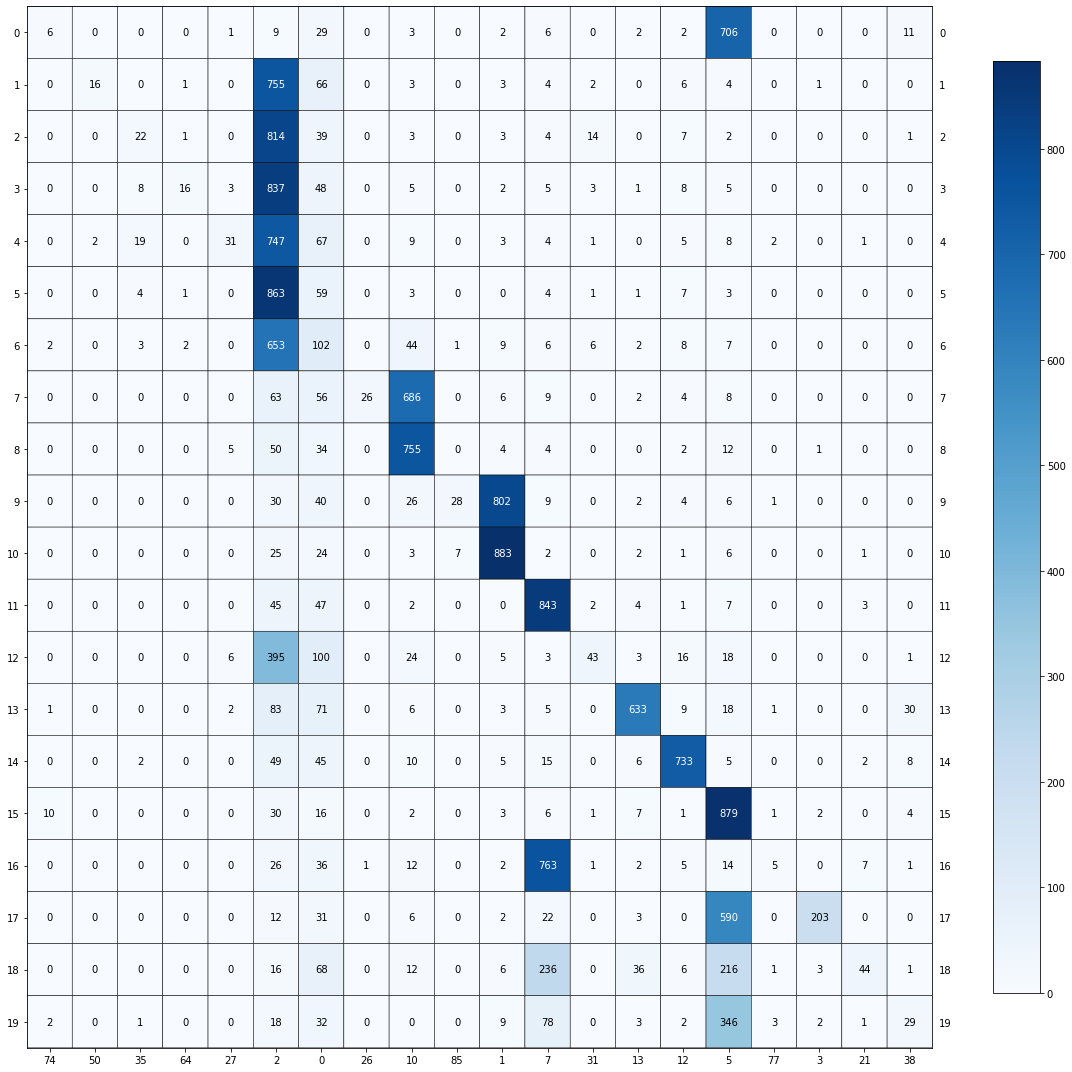

In [ ]:
#Plot the Contigency Matrix
dbscan_best = DBSCAN (eps = 0.3)
y_pred_20_dbscan = dbscan_best.fit_predict(umap_dbscan_embedding)
con_mat_20_cate_dbscan = contingency_matrix(y_20_cate, y_pred_20_dbscan)
rows, cols = linear_sum_assignment(con_mat_20_cate_dbscan, maximize=True)
plot_mat(con_mat_20_cate_dbscan[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

In [ ]:
# Number of clusters in labels, ignoring noise if present.
num_of_clusters = len(set(dbscan_best.labels_)) - (1 if -1 in dbscan_best.labels_ else 0)
print("Number of Clusters: -- "+ str(num_of_clusters)) 
num_of_noise = list(dbscan_best.labels_).count(-1)
print("Number of Noise Datapoints: -- "+ str(num_of_noise)) 

Number of Clusters: -- 155
Number of Noise Datapoints: -- 1010


#### HDBSCAN

In [ ]:
def hdbscan_best_mcs(umap_embedding,label,mcs_list,results):
  for mcs in mcs_list:

    print("==== HDBSCAN min_cluster_size = {} ====".format(mcs))

    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=mcs)
    y_pred_20_umap = hdbscan_model.fit_predict(umap_embedding)
    con_mat_20_cate_umap = contingency_matrix(label, y_pred_20_umap)
    homogeneity_20_cate_umap = metrics.homogeneity_score(label,y_pred_20_umap)
    completeness_20_cate_umap = metrics.completeness_score(label,y_pred_20_umap)
    v_measure_20_cate_umap = metrics.v_measure_score(label,y_pred_20_umap)
    adjusted_rand_index_20_cate_umap = metrics.adjusted_rand_score(label,y_pred_20_umap)
    adjusted_mutual_info_20_cate_umap = metrics.adjusted_mutual_info_score(label,y_pred_20_umap)

    results["homogeneity"].append(homogeneity_20_cate_umap)
    results["completeness"].append(completeness_20_cate_umap)
    results["v_measure"].append(v_measure_20_cate_umap)
    results["adjusted_rand_index"].append(adjusted_rand_index_20_cate_umap)
    results["adjusted_mutual_info"].append(adjusted_mutual_info_20_cate_umap)
    print("Homogeneity: \t\t", homogeneity_20_cate_umap)
    print("Completeness: \t\t", completeness_20_cate_umap)
    print("V-measure:    \t\t", v_measure_20_cate_umap)
    print("Adjusted Rand: \t\t", adjusted_rand_index_20_cate_umap)
    print("Adjusted mutual info: \t", adjusted_mutual_info_20_cate_umap)

In [ ]:
umap_hdbscan = umap.UMAP(n_components=20, metric='cosine')
umap_hdbscan_embedding = umap_hdbscan.fit_transform(tfidf_matrix_20_cate)

In [ ]:
mcs_list = [100,170,200]
results_hdbscan = {
    "homogeneity": [],
    "completeness": [],
    "v_measure": [],
    "adjusted_rand_index": [],
    "adjusted_mutual_info": []
}

In [ ]:
hdbscan_best_mcs(umap_hdbscan_embedding,y_20_cate,mcs_list,results_hdbscan)

==== HDBSCAN min_cluster_size = 100 ====
Homogeneity: 		 0.42533582661541225
Completeness: 		 0.6185199576492612
V-measure:    		 0.5040518075975402
Adjusted Rand: 		 0.2125326667023847
Adjusted mutual info: 	 0.5029521923361047
==== HDBSCAN min_cluster_size = 170 ====
Homogeneity: 		 0.42437314223474704
Completeness: 		 0.6137889329829664
V-measure:    		 0.5018012974597816
Adjusted Rand: 		 0.21355033403002427
Adjusted mutual info: 	 0.5006991637167756
==== HDBSCAN min_cluster_size = 200 ====
Homogeneity: 		 0.42041044830587443
Completeness: 		 0.6155440699375601
V-measure:    		 0.4995994589284899
Adjusted Rand: 		 0.21879853457021733
Adjusted mutual info: 	 0.49858984875380913


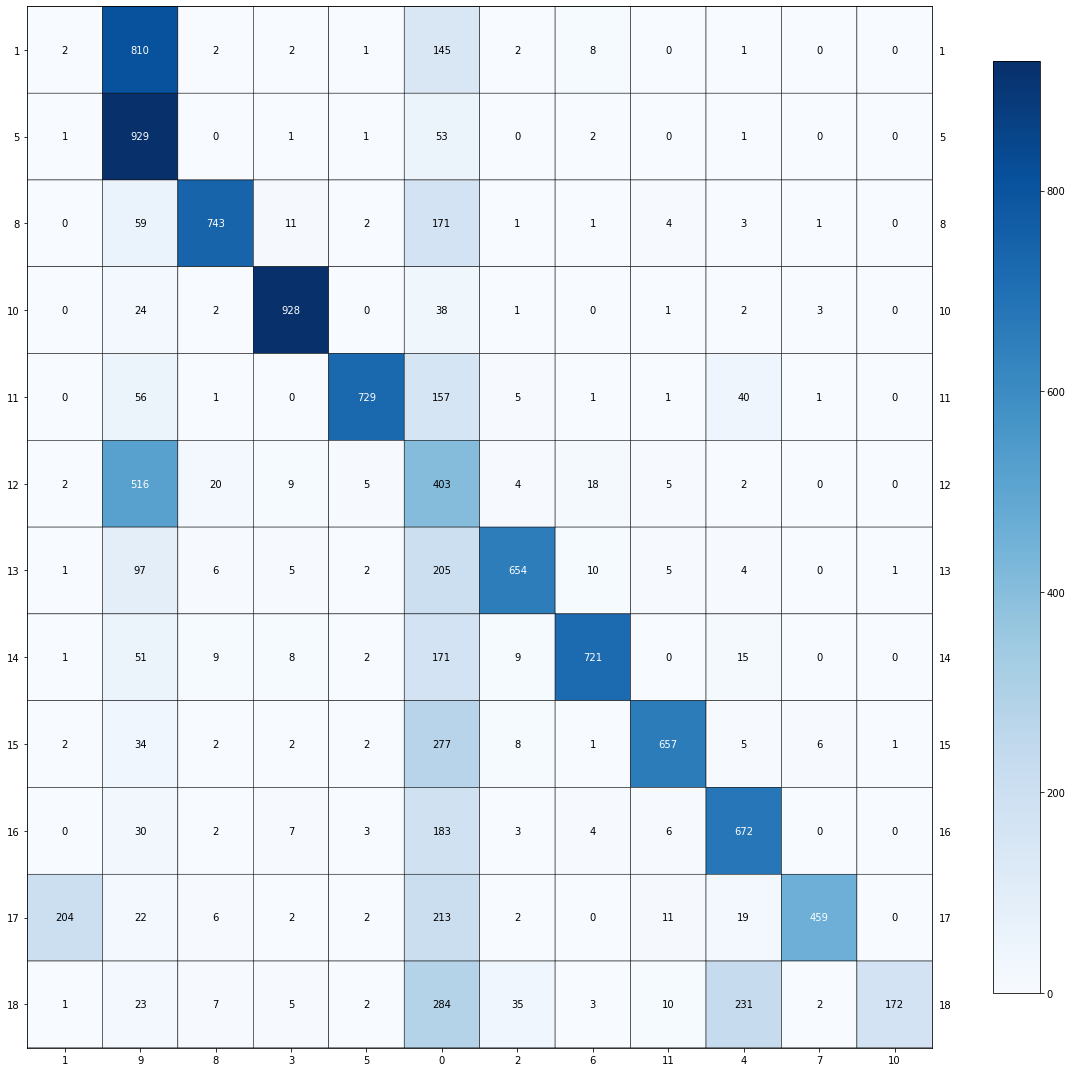

In [ ]:
#Plot the Contigency Matrix for min_cluster_size = 100
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size= 100)
y_pred_20_hdbscan = hdbscan_model.fit_predict(umap_hdbscan_embedding)
con_mat_20_cate_hdbscan = contingency_matrix(y_20_cate, y_pred_20_hdbscan)
rows, cols = linear_sum_assignment(con_mat_20_cate_hdbscan, maximize=True)
plot_mat(con_mat_20_cate_hdbscan[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

In [ ]:
# Number of clusters in labels, ignoring noise if present.
num_of_clusters = len(set(hdbscan_model.labels_)) - (1 if -1 in hdbscan_model.labels_ else 0)
print("Number of Clusters: -- "+ str(num_of_clusters)) 
num_of_noise = list(hdbscan_model.labels_).count(-1)
print("Number of Noise Datapoints: -- "+ str(num_of_noise)) 

Number of Clusters: -- 11
Number of Noise Datapoints: -- 3688


# Deep Learning and Clustering of Image Data

## VGG16 Feature Extractor

In [ ]:
# Code for Part 2
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            #print(x.shape)
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 58/58 [00:27<00:00,  2.09it/s]


In [ ]:
print(f"The feature dimension is {f_all.shape[1]}")

The feature dimension is 4096


In [ ]:
non_zero_percent = np.count_nonzero(f_all)/(f_all.shape[0]*f_all.shape[1])*100
print(f"The feature contains {non_zero_percent}% non-zero entry")

The feature contains 100.0% non-zero entry


## t-SNE visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


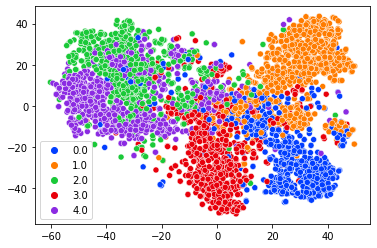

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
f_tSNE = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(f_all)
palette = sns.color_palette("bright", 5)
sns.scatterplot(f_tSNE[:,0], f_tSNE[:,1], hue=y_all, legend='full', palette=palette)

## Dimesionality Reduction Comparison

### Without Dimensionality Reduction

In [ ]:
#Using k-means
km_5 = KMeans(
    n_clusters=5,
    random_state=0,
    max_iter=1000,
    n_init=30
)

In [ ]:
print("Without Dimensionality Reduction Method.\n")
y_pred = km_5.fit_predict(f_all)
assert(len(y_all)==len(y_pred))
rand_ind = metrics.adjusted_rand_score(y_all,y_pred)
print("Adjusted Rand Index: \t\t", rand_ind)

Without Dimensionality Reduction Method.

Adjusted Rand Index: 		 0.18983487300497004


### SVD 

In [ ]:
# r= 50
print("With SVD Dimensionality Reduction Method.\n")
svd_vgg = TruncatedSVD(n_components=50)
X_svd_vgg = svd_vgg.fit_transform(f_all)
y_pred_svd = km_5.fit_predict(X_svd_vgg)
assert(len(y_all)==len(y_pred_svd))
rand_ind_svd = metrics.adjusted_rand_score(y_all,y_pred_svd)
print("Adjusted Rand Index: \t\t", rand_ind_svd)

With SVD Dimensionality Reduction Method.

Adjusted Rand Index: 		 0.19488674542451673


### UMAP

In [ ]:
#n_components = 50
print("With UMAP Dimensionality Reduction Method.\n")
umap_vgg = umap.UMAP(n_components=50, metric='cosine')
umap_vgg_embedding = umap_vgg.fit_transform(f_all)
y_pred_umap = km_5.fit_predict(umap_vgg_embedding)
assert(len(y_all)==len(y_pred_umap))
rand_ind_umap = metrics.adjusted_rand_score(y_all,y_pred_umap)
print("Adjusted Rand Index: \t\t", rand_ind_umap)

With UMAP Dimensionality Reduction Method.

Adjusted Rand Index: 		 0.4659567853101984


### Autoencoder

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [ ]:
#n_components = 50
print("With Autoencoder Dimensionality Reduction Method.\n")
auto_vgg = Autoencoder(50)
X_auto_vgg = auto_vgg.fit_transform(f_all)
y_pred_auto = km_5.fit_predict(X_auto_vgg)
assert(len(y_all)==len(y_pred_auto))
rand_ind_auto = metrics.adjusted_rand_score(y_all,y_pred_auto)
print("Adjusted Rand Index: \t\t", rand_ind_auto)

With Autoencoder Dimensionality Reduction Method.



100%|██████████| 100/100 [00:12<00:00,  7.86it/s]


Adjusted Rand Index: 		 0.1659519290733323


## Clustering Method Comparison

In [ ]:
# Using UMAP as dimensionality reduction method
umap_vgg = umap.UMAP(n_components=50, metric='cosine')
umap_vgg_embedding = umap_vgg.fit_transform(f_all)

### K-Means

In [ ]:
# k = 5
km_5 = KMeans(
    n_clusters=5,
    random_state=0,
    max_iter=1000,
    n_init=30
)
y_pred_km = km_5.fit_predict(umap_vgg_embedding)
assert(len(y_all)==len(y_pred_km))
rand_ind_km = metrics.adjusted_rand_score(y_all,y_pred_km)
print("Adjusted Rand Index: \t\t", rand_ind_km)

Adjusted Rand Index: 		 0.4651455716058402


### Agglomerative Clustering

In [ ]:
# n_clusters= 5
agg_ward_5 = AgglomerativeClustering(
    n_clusters= 5,
    linkage='ward'
)
y_pred_agg = agg_ward_5.fit_predict(umap_vgg_embedding)
assert(len(y_all)==len(y_pred_agg))
rand_ind_agg = metrics.adjusted_rand_score(y_all,y_pred_agg)
print("Adjusted Rand Index: \t\t", rand_ind_agg)

Adjusted Rand Index: 		 0.4591547734367751


### HDBSCAN

In [ ]:
min_cluster_size_list = [10, 50, 100,170,200]
min_samples_list = [None,1,3]

In [ ]:
def hdbscan_vgg(umap_embedding,label,mcs_list,ms_list):
  for mcs in mcs_list:
    for ms in ms_list:
      print("==== HDBSCAN min_cluster_size = {}, min_samples = {} ====".format(mcs,ms))

      hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=mcs,min_samples=ms)
      y_pred_hdbscan = hdbscan_model.fit_predict(umap_embedding)
      assert(len(label) == len(y_pred_hdbscan))
      adjusted_rand_index_hdbscan = metrics.adjusted_rand_score(label,y_pred_hdbscan)
      print("Adjusted Rand Index: \t\t", adjusted_rand_index_hdbscan)

In [ ]:
hdbscan_vgg(umap_vgg_embedding,y_all,min_cluster_size_list,min_samples_list)

==== HDBSCAN min_cluster_size = 10, min_samples = None ====
Adjusted Rand Index: 		 0.09411014415380671
==== HDBSCAN min_cluster_size = 10, min_samples = 1 ====
Adjusted Rand Index: 		 0.09411014415380671
==== HDBSCAN min_cluster_size = 10, min_samples = 3 ====
Adjusted Rand Index: 		 0.09411014415380671
==== HDBSCAN min_cluster_size = 50, min_samples = None ====
Adjusted Rand Index: 		 0.09411014415380671
==== HDBSCAN min_cluster_size = 50, min_samples = 1 ====
Adjusted Rand Index: 		 0.09411014415380671
==== HDBSCAN min_cluster_size = 50, min_samples = 3 ====
Adjusted Rand Index: 		 0.09411014415380671
==== HDBSCAN min_cluster_size = 100, min_samples = None ====
Adjusted Rand Index: 		 0.09411014415380671
==== HDBSCAN min_cluster_size = 100, min_samples = 1 ====
Adjusted Rand Index: 		 0.09411014415380671
==== HDBSCAN min_cluster_size = 100, min_samples = 3 ====
Adjusted Rand Index: 		 0.09411014415380671
==== HDBSCAN min_cluster_size = 170, min_samples = None ====
Adjusted Rand Inde

## MLP Classifier

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################

                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                #pdb.set_trace()
                loss = criterion(output,y_.cuda())

                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return self
    
    def eval(self, X_test, y_test):
        X_pred = self(torch.tensor(X_test,dtype=torch.float32, device='cuda'))
        logit = X_pred.argmax(dim=1)
  
        # accuracy
        acc = torch.sum(logit == torch.tensor(y_test,dtype=torch.float32, device='cuda'))/X_test.shape[0]
        with torch.no_grad():
          acc = acc.cpu().numpy()
        return acc

### Using original VGG features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

In [ ]:
model = MLP(4096)
print("Using original VGG features.\n")
model.train(X_train, y_train)
acc = model.eval(X_test, y_test)
print(f"\nAccuracy: {acc}")

Using original VGG features.



100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


Accuracy: 0.9100817441940308


### Using the reduced-dimension features with UMAP

In [ ]:
# Use UMAP with n_components = {100, 50, 20, 10, 5, 2}
def umap_dl_model(n_component, f_all, y_all):
  umap_feature = umap.UMAP(n_components=n_component, metric='cosine')
  umap_feature_embedding = umap_feature.fit_transform(f_all)

  model = MLP(n_component)
  X_train, X_test, y_train, y_test = train_test_split(umap_feature_embedding, y_all, test_size=0.2, random_state=42)
  model.train(X_train, y_train)
  acc = model.eval(X_test, y_test)
  print(f"Dimension: {n_component} Accuracy: {acc}\n")
  return acc

In [ ]:
print("Using UMAP as dimension reduction method.\n")
acc_umap_100 = umap_dl_model(100, f_all, y_all)
acc_umap_50 = umap_dl_model(50, f_all, y_all)
acc_umap_20 = umap_dl_model(20, f_all, y_all)
acc_umap_10 = umap_dl_model(10, f_all, y_all)
acc_umap_5 = umap_dl_model(5, f_all, y_all)
acc_umap_2 = umap_dl_model(2, f_all, y_all)

Using UMAP as dimension reduction method.



100%|██████████| 100/100 [00:04<00:00, 20.72it/s]


Dimension: 100 Accuracy: 0.8378746509552002



100%|██████████| 100/100 [00:05<00:00, 19.92it/s]


Dimension: 50 Accuracy: 0.8365122675895691



100%|██████████| 100/100 [00:04<00:00, 20.52it/s]


Dimension: 20 Accuracy: 0.8514986038208008



100%|██████████| 100/100 [00:04<00:00, 20.13it/s]


Dimension: 10 Accuracy: 0.8583106398582458



100%|██████████| 100/100 [00:04<00:00, 20.86it/s]


Dimension: 5 Accuracy: 0.8378746509552002



100%|██████████| 100/100 [00:04<00:00, 20.63it/s]

Dimension: 2 Accuracy: 0.8337874412536621

